In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import pymc3 as pm
import theano.tensor as tt
import exoplanet as xo

plotpar = {'axes.labelsize': 30,
                  'font.size': 22,
                  'legend.fontsize': 15,
                  'xtick.labelsize': 30,
                  'ytick.labelsize': 30,
                  'text.usetex': True}
plt.rcParams.update(plotpar)

In [3]:
df = pd.read_csv("../data/twins.csv")

In [4]:
df

,#HIP,Teff,Teff_err,[M/H],[M/H]_err,<S>,<S>_err,M_iso,M_err,Age_iso,Age_err,Source
0,1954,5720,2,-0.090,0.003,0.177,0.004,0.970,0.002,4.4,0.5,LO18
1,3203,5868,9,-0.050,0.007,0.314,0.013,1.038,0.004,0.5,0.3,LO18
2,4909,5861,7,0.048,0.006,0.282,0.012,1.055,0.005,0.6,0.4,LO18
3,5301,5723,3,-0.074,0.003,0.165,0.002,0.960,0.001,7.2,0.4,LO18
4,6407,5775,7,-0.058,0.006,0.223,0.004,1.004,0.005,1.9,0.7,LO18
...,...,...,...,...,...,...,...,...,...,...,...,...
74,114615,5819,5,-0.063,0.004,0.204,0.006,1.027,0.005,1.1,0.7,LO18
75,115577,5694,4,0.013,0.003,0.154,0.001,1.019,0.002,8.8,0.3,LO18
76,116906,5790,3,-0.005,0.003,0.161,0.002,1.010,0.001,6.7,0.3,LO18
77,117367,5867,3,0.024,0.003,0.159,0.001,1.040,0.001,5.7,0.3,LO18


In [5]:
def r_prime_hk_from_sindex_and_teff(sindex, teff, mh):
    log_C_cf = - 7.31 + 2.25e-3 * teff - 1.70e-7 * teff**2
    log_r_phot = - 4.78845 - (3.70700 / (1. + (teff/4598.92)**17.5272))
    log_r_hk = np.log10(1.34e-4 * 10**log_C_cf * sindex)
    return log_r_hk + 0.5 * mh 

log_r_prime_hk = r_prime_hk_from_sindex_and_teff(df["<S>"], df.Teff, df["[M/H]"])

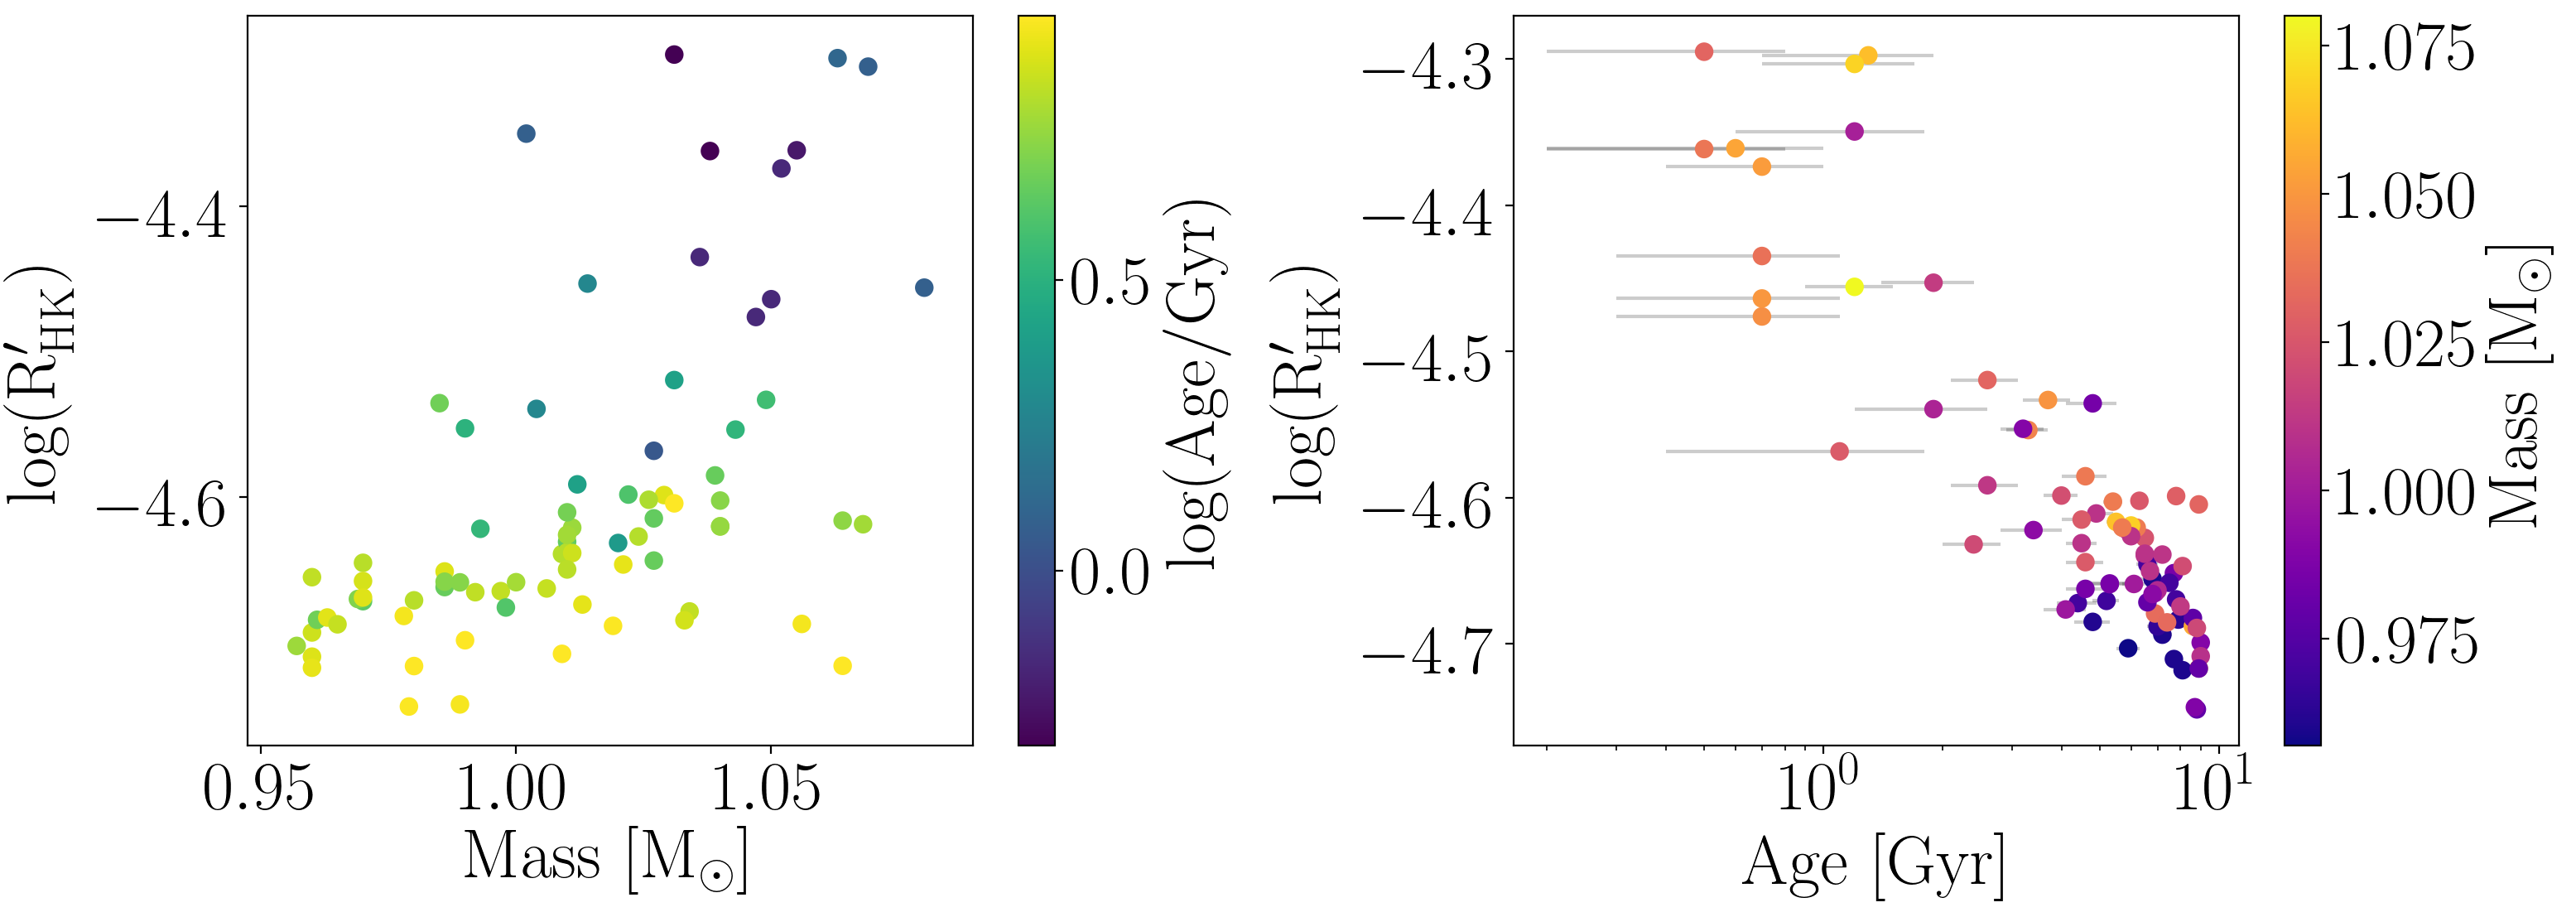

In [6]:
fig = plt.figure(figsize=(16, 6), dpi=200)
ax0 = fig.add_subplot(121)
cb = ax0.scatter(df.M_iso, log_r_prime_hk, c=np.log10(df["Age_iso"]), s=50)
plt.colorbar(cb, label="$\mathrm{log(Age/Gyr)}$")
ax0.set_xlabel("$\mathrm{Mass~[M_\odot]}$")
ax0.set_ylabel("$\mathrm{\log(R'_{HK})}$");
# ax0.set_xscale("log")

ax1 = fig.add_subplot(122)
ax1.errorbar(df["Age_iso"], log_r_prime_hk, xerr=df["Age_err"], alpha=.2, fmt="k.", zorder=0)
cb = ax1.scatter(df["Age_iso"], log_r_prime_hk, c=df.M_iso, s=50, zorder=1, cmap="plasma")
plt.colorbar(cb, label="$\mathrm{Mass~[M_\odot]}$")
ax1.set_xlabel("$\mathrm{Age~[Gyr]}$")
ax1.set_ylabel("$\mathrm{\log(R'_{HK})}$");
ax1.set_xscale("log")

plt.tight_layout()

In [7]:
rhk = log_r_prime_hk
mass = df.M_iso.values
age, age_err = np.log(df["Age_iso"].values), df["Age_err"].values/df["Age_iso"].values

In [8]:
with pm.Model() as model:
    
    # Parameters to infer.
    m = pm.Normal("m", mu=0.0, sd=5)                           # Slope (mass)
    b = pm.Normal("b", mu=-5, sd=5)                            # Intercept
    a = pm.Normal("a", mu=0.0, sd=5)                            # Slope (age)
    
    def get_mean_model(mass, age):
        return m * mass + b + a*age
    
    mean_model = get_mean_model(mass, age)
    pm.Deterministic("mean_model", mean_model)
    
    # Likelihood
    pm.Normal("obs", mu=mean_model, observed=rhk)
        
    map_soln = model.test_point
    map_soln = xo.optimize(map_soln, [m, b, a])
    
    print("done")

optimizing logp for variables: [a, b, m]



done


message: Optimization terminated successfully.
logp: -86.77810629627245 -> -80.26705325119428


In [9]:
def model(mass, age, map_soln):
    return map_soln["m"] * mass + map_soln["b"] + map_soln["a"]*age

In [10]:
def get_color(x2, vmin, vmax, cmap):
    return cmap((x2 - vmin) / (vmax - vmin))

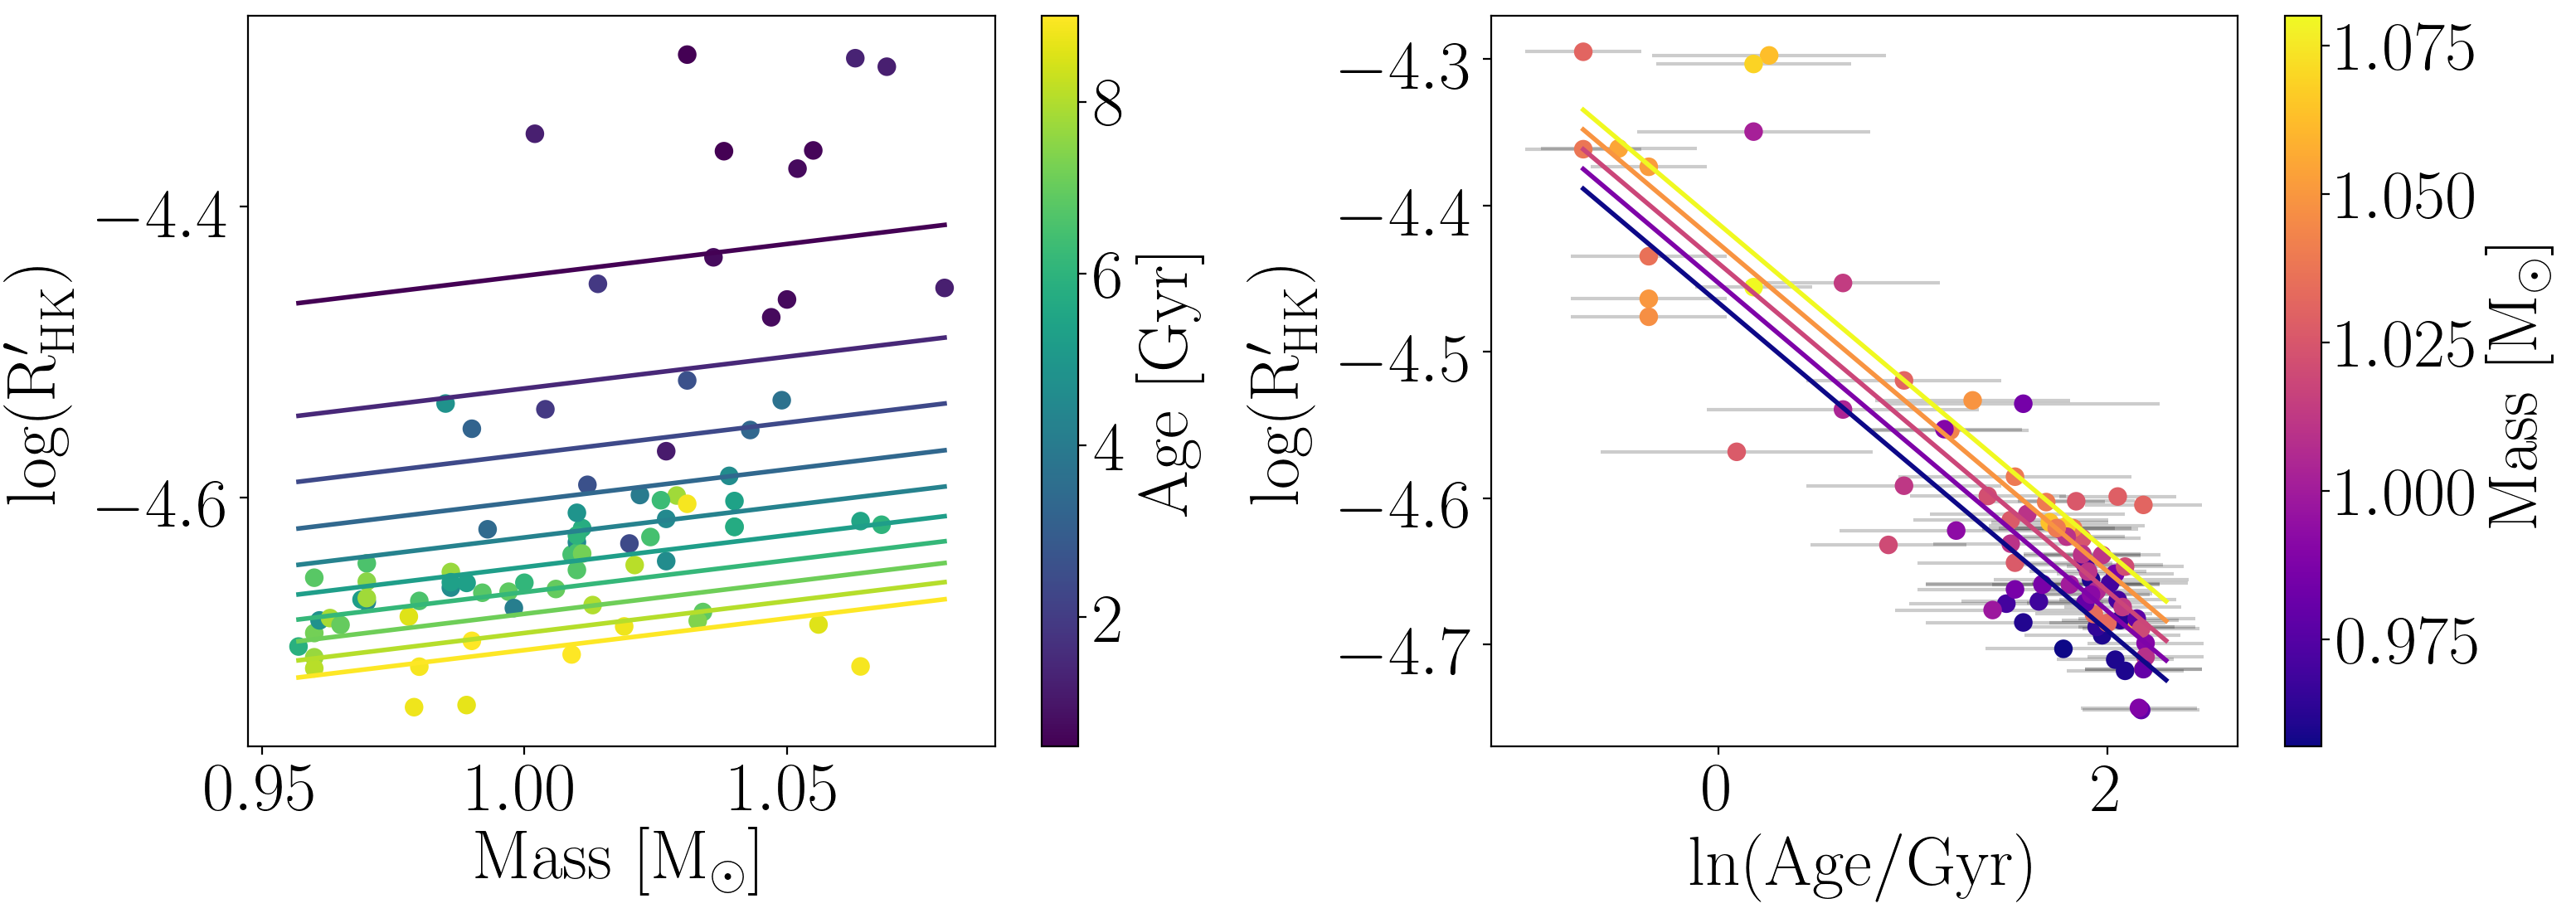

In [11]:
fig = plt.figure(figsize=(16, 6), dpi=200)
ax0 = fig.add_subplot(121)
cb = ax0.scatter(df.M_iso, log_r_prime_hk, c=df["Age_iso"], s=50)
plt.colorbar(cb, label="$\mathrm{Age~[Gyr]}$")
ax0.set_xlabel("$\mathrm{Mass~[M_\odot]}$")
ax0.set_ylabel("$\mathrm{\log(R'_{HK})}$");
masses = np.linspace(min(mass), max(mass), 100)
# ax0.plot(masses, map_soln["m"]*masses + map_soln["b"])

masses = np.linspace(min(mass), max(mass), 100)
rhks = np.linspace(min(rhk), max(rhk), 100)
rhk_plot = np.linspace(min(rhk), max(rhk), 10)
ages = np.log(np.linspace(.5, 10, 100))
age_plot = np.linspace(1, 10, 10)
mass_plot = np.linspace(min(mass), max(mass), 5)

vmin = age_plot.min()
vmax = age_plot.max()
cmap = matplotlib.cm.get_cmap("viridis")

for i in range(len(age_plot)):
    plt.plot(masses, model(masses, np.log(age_plot[i]), map_soln), color=get_color(age_plot[i], vmin, vmax, cmap), lw=2)

ax1 = fig.add_subplot(122)
ax1.errorbar(age, log_r_prime_hk, xerr=df["Age_err"], alpha=.2, fmt="k.", zorder=0)
cb = ax1.scatter(age, log_r_prime_hk, c=df.M_iso, s=50, zorder=1, cmap="plasma")
plt.colorbar(cb, label="$\mathrm{Mass~[M_\odot]}$")
ax1.set_xlabel("$\mathrm{\ln(Age/Gyr)}$")
ax1.set_ylabel("$\mathrm{\log(R'_{HK})}$");

vmin = mass.min()
vmax = mass.max()
cmap = matplotlib.cm.get_cmap("plasma")

for i in range(len(mass_plot)):
#     ax1.plot(ages, model(mass_plot[i], ages, map_soln), color="k", lw=1.25)
    plt.plot(ages, model(mass_plot[i], ages, map_soln), color=get_color(mass_plot[i], vmin, vmax, cmap), lw=2)
    
plt.tight_layout()

In [33]:
# fig = plt.figure(figsize=(16, 6), dpi=200)
# ax0 = fig.add_subplot(121)
# cb = ax0.scatter(df.M_iso, log_r_prime_hk, c=np.log10(df["Age_iso"]), s=50)
# plt.colorbar(cb, label="$\mathrm{log(Age/Gyr)}$")
# ax0.set_xlabel("$\mathrm{Mass~[M_\odot]}$")
# ax0.set_ylabel("$\mathrm{\log(R'_{HK})}$");
# # ax0.set_xscale("log")

# ax1 = fig.add_subplot(122)
# ax1.errorbar(log_r_prime_hk, df["Age_iso"], yerr=df["Age_err"], alpha=.2, fmt="k.", zorder=0)
# cb = ax1.scatter(log_r_prime_hk, df["Age_iso"], c=df.M_iso, s=50, zorder=1, cmap="plasma")
# plt.colorbar(cb, label="$\mathrm{Mass~[M_\odot]}$")
# ax1.set_ylabel("$\mathrm{Age~[Gyr]}$")
# ax1.set_xlabel("$\mathrm{\log(R'_{HK})}$");
# ax1.set_yscale("log")
# ax1.axvline(-4.5)

# plt.tight_layout()

$$P = a t^n C^b$$
$$t = d P^{1/n} C^{-b}$$
$$t = c (R\prime_{HK})^\alpha M^\beta $$

In [30]:
rhk = log_r_prime_hk
rhk_min = min(rhk)
mass = df.M_iso.values
rhk_plot = np.linspace(min(rhk), max(rhk), 5)
mass_plot = np.linspace(mass.min() - .2, mass.max() + .2, 1000)
age, age_err = np.log(df["Age_iso"].values), df["Age_err"].values/df["Age_iso"].values

with pm.Model() as model:
    # x1 is color (now mass), x2 is age (now R'HK), y is period (now age)
    
    # Parameters to infer.
    rhk_break = pm.Normal("rhk_break", mu=-4.5, sigma=.1)                      # the break in R'HK
    log_rhk_m = pm.Normal("log_rhk_m", mu=0.0, sd=5)                           # The weight of the x term
    log_rhk_b = pm.Normal("log_rhk_b", mu=np.log(10), sd=5)                    # The constant term
    log_smooth = pm.Normal("log_smooth", mu=np.log(0.01), sigma=10.0)          # The smoothness of the break. (lower is smoother)
    smooth = tt.exp(log_smooth)
    slope_low = pm.Normal("slope_low", mu=0.0, sd=10.0)                        # The slope below the break
    slope_high = pm.Normal("slope_high", mu=0.0, sd=10.0)                      # The slope above the break
    
    def get_age_rhk(rhk):
        """
        2nd-order polynomial describing relationship between age and R'HK.
        log(t) = m*log(R'HK) + b
        """
        return log_rhk_m * (rhk - rhk_min) + log_rhk_b
    
    # Mean model
    def get_mean_model(mass, rhk):
        """
        Predict the age at given values of mass and R'HK.
        Use a smoothed broken power law for the age - mass relation.
        Use get_age_rhk for the age - R'HK relation.
        """
        delta = mass - rhk_break
        brk = get_age_rhk(rhk)  # Get the period at this age
        slope = slope_low / (1 + tt.exp(smooth * delta)) + slope_high / (1 + tt.exp(-smooth * delta))
        return slope * delta + brk
    
    mean_model = get_mean_model(mass, rhk)
    pm.Deterministic("mean_model", mean_model)
    
    for i, rhk_ref in enumerate(rhk_plot):
        pred = get_mean_model(mass_plot, rhk_ref)
        pm.Deterministic("pred_{0}".format(i), pred)
    
    # Likelihood
#     pm.MvNormal("obs", mu=mean_model, sig=age_err, observed=age)
    pm.Normal("obs", mu=mean_model, sigma=age_err, observed=age)
        
    mass_test = pm.Flat("mass_test", shape=(5000,))
    rhk_test = pm.Flat("rhk_test", shape=(5000,))
    age_test = pm.Deterministic("age_test", get_mean_model(mass_test, rhk_test))
        
    map_soln = model.test_point
    map_soln = xo.optimize(map_soln, [slope_low, slope_high])
    map_soln = xo.optimize(map_soln, [log_smooth])
    map_soln = xo.optimize(map_soln, [rhk_break, log_rhk_m, log_rhk_b])
    map_soln = xo.optimize(map_soln, [slope_low, slope_high, log_smooth])
    map_soln = xo.optimize(map_soln, [slope_high, slope_low, log_smooth, log_rhk_b, log_rhk_m, rhk_break])
    
    print("done")

optimizing logp for variables: [slope_high, slope_low]


message: Optimization terminated successfully.
logp: -6195.225560528894 -> -2053.983255216851
optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -2053.983255216851 -> -2053.9707888471785
optimizing logp for variables: [log_rhk_b, log_rhk_m, rhk_break]


message: Optimization terminated successfully.
logp: -2053.9707888471785 -> -501.532230642799
optimizing logp for variables: [log_smooth, slope_high, slope_low]


message: Desired error not necessarily achieved due to precision loss.
logp: -501.532230642799 -> -490.1201675676556
optimizing logp for variables: [rhk_break, log_rhk_m, log_rhk_b, log_smooth, slope_low, slope_high]



done


message: Optimization terminated successfully.
logp: -490.1201675676556 -> -488.92176597378216


In [44]:
mass_min = min(mass)
mass_plot = np.linspace(mass.min() - .2, mass.max() + .2, 5)
age, age_err = np.log(df["Age_iso"].values), df["Age_err"].values/df["Age_iso"].values
age_plot = np.linspace(min(age)-.1, max(age)+.1, 1000)

with pm.Model() as model:
    # x1 is age, x2 is mass, y is R'HK
    
    # Parameters to infer.
    age_break = pm.Normal("age_break", mu=1, sigma=.3)                         # the break in age
    log_rhk_m = pm.Normal("log_rhk_m", mu=0.0, sd=5)                           # The weight of the x term
    log_rhk_b = pm.Normal("log_rhk_b", mu=np.log(10), sd=5)                    # The constant term
    log_smooth = pm.Normal("log_smooth", mu=np.log(0.01), sigma=10.0)          # The smoothness of the break. (lower is smoother)
    smooth = tt.exp(log_smooth)
    slope_low = pm.Normal("slope_low", mu=0.0, sd=10.0)                        # The slope below the break
    slope_high = pm.Normal("slope_high", mu=0.0, sd=10.0)                      # The slope above the break
    
    def get_rhk_mass(mass):
        """
        2nd-order polynomial describing relationship between R'HK and mass.
        log(R'HK) = m*log(mass) + b
        """
        return log_rhk_m * (mass - mass_min) + log_rhk_b
    
    # Mean model
    def get_mean_model(mass, age):
        """
        Predict the age at given values of mass and log(age).
        Use a smoothed broken power law for the age - mass relation.
        Use get_rhk_mass for the R'HK-mass relation.
        """
        delta = age - age_break
        brk = get_rhk_mass(mass)  # Get the rhk at this mass
        slope = slope_low / (1 + tt.exp(smooth * delta)) + slope_high / (1 + tt.exp(-smooth * delta))
        return slope * delta + brk
    
    mean_model = get_mean_model(mass, age)
    pm.Deterministic("mean_model", mean_model)
    
    for i, mass_ref in enumerate(mass_plot):
        pred = get_mean_model(mass_ref, age_plot)
        pm.Deterministic("pred_{0}".format(i), pred)
    
    # Likelihood
    pm.Normal("obs", mu=mean_model, observed=rhk)
        
    mass_test = pm.Flat("mass_test", shape=(5000,))
    age_test = pm.Flat("age_test", shape=(5000,))
    rhk_test = pm.Deterministic("rhk_test", get_mean_model(mass_test, age_test))
        
    map_soln = model.test_point
    map_soln = xo.optimize(map_soln, [slope_low, slope_high])
    map_soln = xo.optimize(map_soln, [log_smooth])
    map_soln = xo.optimize(map_soln, [age_break, log_rhk_m, log_rhk_b])
    map_soln = xo.optimize(map_soln, [slope_low, slope_high, log_smooth])
    map_soln = xo.optimize(map_soln, [slope_high, slope_low, log_smooth, log_rhk_b, log_rhk_m, age_break])
    
    print("done")

optimizing logp for variables: [slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1972.5530666345155 -> -1401.2822007698353
optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -1401.2822007698353 -> -691.6068303004961
optimizing logp for variables: [log_rhk_b, log_rhk_m, age_break]


message: Optimization terminated successfully.
logp: -691.6068303004961 -> -435.9781478189015
optimizing logp for variables: [log_smooth, slope_high, slope_low]


message: Optimization terminated successfully.
logp: -435.9781478189015 -> -180.5994427859377
optimizing logp for variables: [age_break, log_rhk_m, log_rhk_b, log_smooth, slope_low, slope_high]



done


message: Optimization terminated successfully.
logp: -180.5994427859377 -> -88.06159655773591


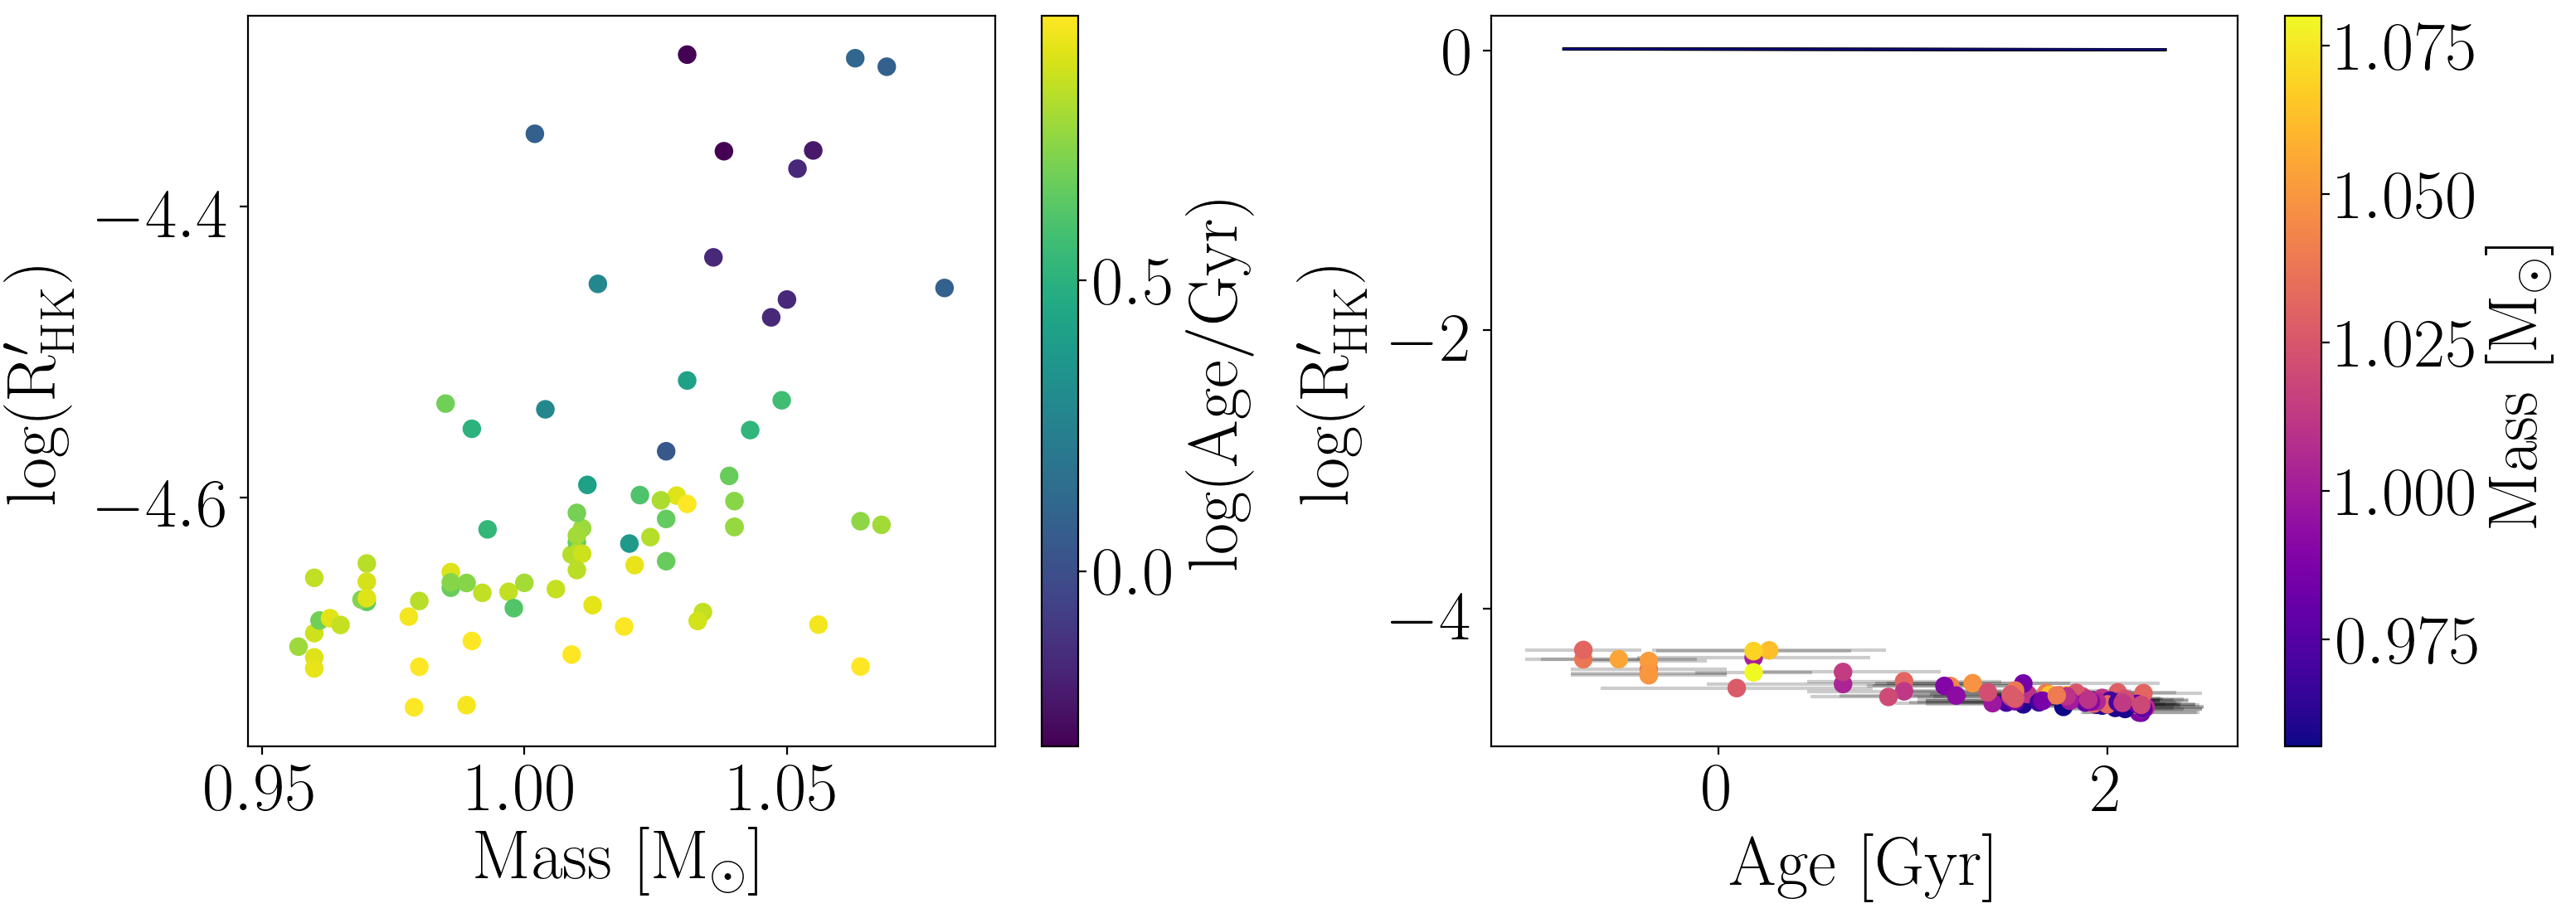

In [45]:
fig = plt.figure(figsize=(16, 6), dpi=200)
ax0 = fig.add_subplot(121)
cb = ax0.scatter(df.M_iso, log_r_prime_hk, c=np.log10(df["Age_iso"]), s=50)
plt.colorbar(cb, label="$\mathrm{log(Age/Gyr)}$")
ax0.set_xlabel("$\mathrm{Mass~[M_\odot]}$")
ax0.set_ylabel("$\mathrm{\log(R'_{HK})}$");
# ax0.set_xscale("log")

ax1 = fig.add_subplot(122)
ax1.errorbar(age, log_r_prime_hk, xerr=df["Age_err"], alpha=.2, fmt="k.", zorder=0)
cb = ax1.scatter(age, log_r_prime_hk, c=df.M_iso, s=50, zorder=1, cmap="plasma")
plt.colorbar(cb, label="$\mathrm{Mass~[M_\odot]}$")
ax1.set_xlabel("$\mathrm{Age~[Gyr]}$")
ax1.set_ylabel("$\mathrm{\log(R'_{HK})}$");
# ax1.set_xscale("log")

import matplotlib
cmap = matplotlib.cm.get_cmap("plasma_r")

vmin = np.exp(mass).min()
vmax = np.exp(mass).max()

def get_color(x2):
    return cmap((np.exp(x2) - vmin) / (vmax - vmin))

for i in range(len(mass_plot)):
    ax1.plot(age_plot, np.exp(map_soln["pred_{0}".format(i)]), color="k", lw=1.25)
    plt.plot(age_plot, np.exp(map_soln["pred_{0}".format(i)]), color=get_color(mass_plot[i]), lw=0.75)
    
plt.tight_layout()

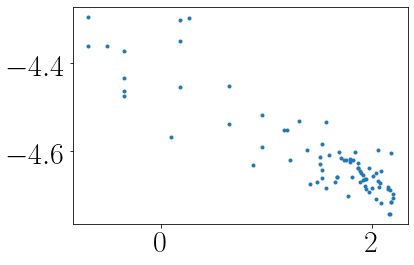

In [66]:
with pm.Model() as model:
    
    # Parameters to infer.
    age_break = pm.Normal("age_break", mu=1, sigma=.3)                         # the break in age
    m = pm.Normal("m", mu=0.0, sd=5)                                           # Slope
    b = pm.Normal("b", mu=-5, sd=5)                                            # Intercept
    log_smooth = pm.Normal("log_smooth", mu=np.log(0.01), sigma=10.0)          # The smoothness of the break. (lower is smoother)
    smooth = tt.exp(log_smooth)
    slope_low = pm.Normal("slope_low", mu=0.0, sd=10.0)                        # The slope below the break
    slope_high = pm.Normal("slope_high", mu=0.0, sd=10.0)                      # The slope above the break
    
    def get_rhk_mass(mass):
        """
        2nd-order polynomial describing relationship between R'HK and mass.
        log(R'HK) = m*log(mass) + b
        """
        return m * mass + b
    
    # Mean model
    def get_mean_model(mass, age):
        """
        Predict the age at given values of mass and log(age).
        Use a smoothed broken power law for the age - mass relation.
        Use get_rhk_mass for the R'HK-mass relation.
        """
        delta = age - age_break
        brk = get_rhk_mass(mass)  # Get the rhk at this mass
        slope = slope_low / (1 + tt.exp(smooth * delta)) + slope_high / (1 + tt.exp(-smooth * delta))
        return slope * delta + brk
    
    mean_model = get_mean_model(mass, age)
    pm.Deterministic("mean_model", mean_model)
    
    for i, mass_ref in enumerate(mass_plot):
        pred = get_mean_model(mass_ref, age_plot)
        pm.Deterministic("pred_{0}".format(i), pred)
    
    # Likelihood
    pm.Normal("obs", mu=mean_model, observed=rhk)
        
    mass_test = pm.Flat("mass_test", shape=(5000,))
    age_test = pm.Flat("age_test", shape=(5000,))
    rhk_test = pm.Deterministic("rhk_test", get_mean_model(mass_test, age_test))
        
    map_soln = model.test_point
    map_soln = xo.optimize(map_soln, [slope_low, slope_high])
    map_soln = xo.optimize(map_soln, [log_smooth])
    map_soln = xo.optimize(map_soln, [age_break, m, b])
    map_soln = xo.optimize(map_soln, [slope_low, slope_high, log_smooth])
    map_soln = xo.optimize(map_soln, [slope_high, slope_low, log_smooth, b, m, age_break])
    
    print("done")

optimizing logp for variables: [slope_high, slope_low]


message: Optimization terminated successfully.
logp: -93.62926645810857 -> -92.77122766217278
optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -92.77122766217278 -> -89.76454587380408
optimizing logp for variables: [b, m, age_break]


message: Optimization terminated successfully.
logp: -89.76454587380408 -> -88.91059340029133
optimizing logp for variables: [log_smooth, slope_high, slope_low]


message: Optimization terminated successfully.
logp: -88.91059340029133 -> -88.02283972868162
optimizing logp for variables: [age_break, m, b, log_smooth, slope_low, slope_high]



done


message: Optimization terminated successfully.
logp: -88.02283972868162 -> -87.11774604037085


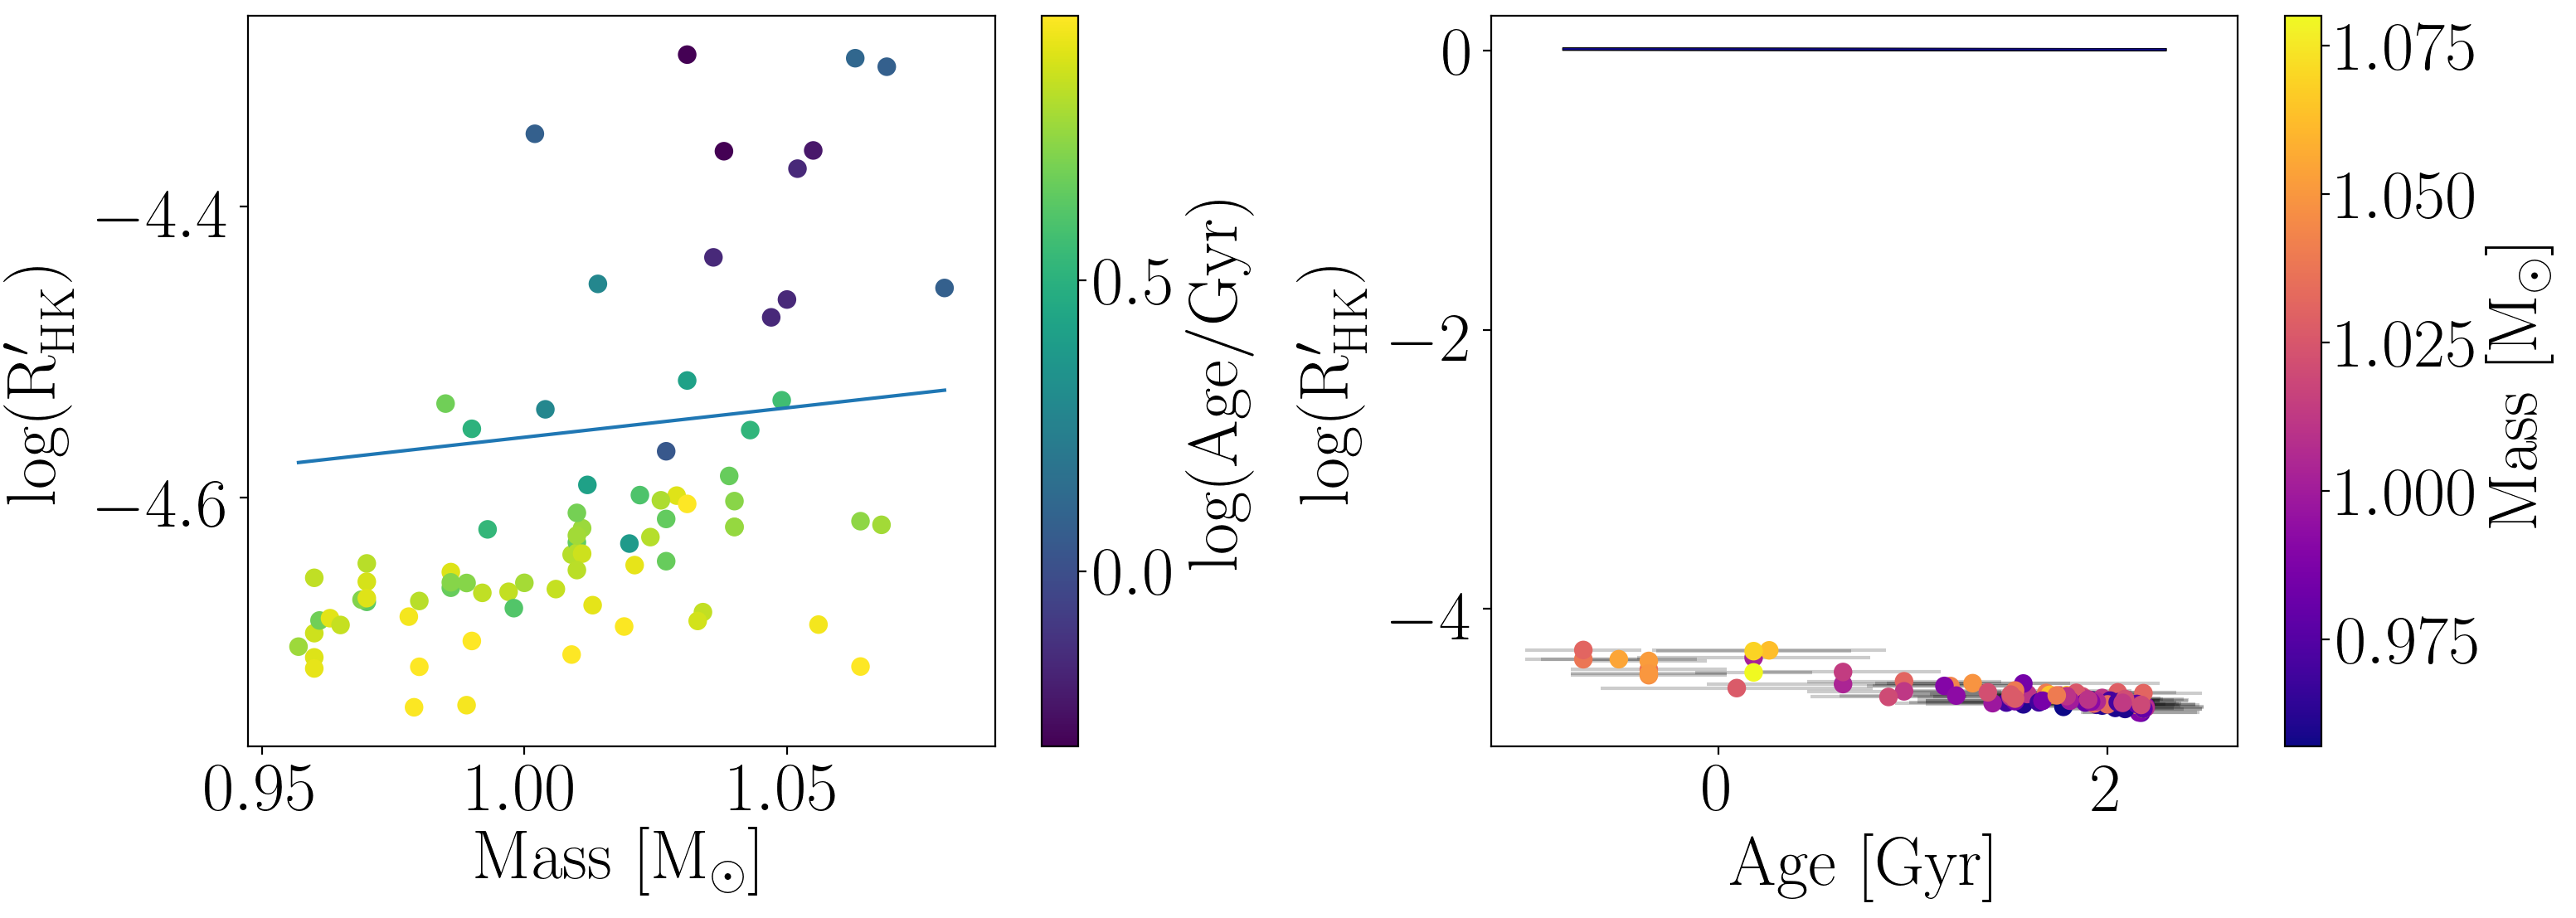

In [68]:
fig = plt.figure(figsize=(16, 6), dpi=200)
ax0 = fig.add_subplot(121)
cb = ax0.scatter(df.M_iso, log_r_prime_hk, c=np.log10(df["Age_iso"]), s=50)
plt.colorbar(cb, label="$\mathrm{log(Age/Gyr)}$")
ax0.set_xlabel("$\mathrm{Mass~[M_\odot]}$")
ax0.set_ylabel("$\mathrm{\log(R'_{HK})}$");
masses = np.linspace(min(mass), max(mass), 100)
ax0.plot(masses, map_soln["m"]*masses + map_soln["b"])
# ax0.set_xscale("log")

ax1 = fig.add_subplot(122)
ax1.errorbar(age, log_r_prime_hk, xerr=df["Age_err"], alpha=.2, fmt="k.", zorder=0)
cb = ax1.scatter(age, log_r_prime_hk, c=df.M_iso, s=50, zorder=1, cmap="plasma")
plt.colorbar(cb, label="$\mathrm{Mass~[M_\odot]}$")
ax1.set_xlabel("$\mathrm{Age~[Gyr]}$")
ax1.set_ylabel("$\mathrm{\log(R'_{HK})}$");
# ax1.set_xscale("log")

import matplotlib
cmap = matplotlib.cm.get_cmap("plasma_r")

vmin = np.exp(mass).min()
vmax = np.exp(mass).max()

def get_color(x2):
    return cmap((np.exp(x2) - vmin) / (vmax - vmin))

for i in range(len(mass_plot)):
    ax1.plot(age_plot, np.exp(map_soln["pred_{0}".format(i)]), color="k", lw=1.25)
    plt.plot(age_plot, np.exp(map_soln["pred_{0}".format(i)]), color=get_color(mass_plot[i]), lw=0.75)
    
plt.tight_layout()

optimizing logp for variables: [b, m]



done


message: Optimization terminated successfully.
logp: -84.24972985063367 -> -78.02249379230187


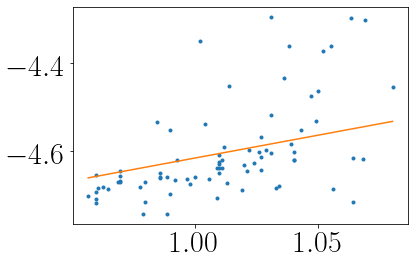

In [64]:
with pm.Model() as model:
    
    # Parameters to infer.
    m = pm.Normal("m", mu=0.0, sd=5)                           # Slope
    b = pm.Normal("b", mu=-5, sd=5)                    # Intercept
    
    def get_mean_model(mass):
        """
        2nd-order polynomial describing relationship between R'HK and age.
        log(R'HK) = m*log(age) + b
        """
        return m * mass + b
    
    mean_model = get_mean_model(mass)
    pm.Deterministic("mean_model", mean_model)
    
    # Likelihood
    pm.Normal("obs", mu=mean_model, observed=rhk)
        
    map_soln = model.test_point
    map_soln = xo.optimize(map_soln, [m, b])
    
    print("done")
    
plt.plot(mass, rhk, ".")
masses = np.linspace(min(mass), max(mass), 100)
plt.plot(masses, map_soln["m"]*masses + map_soln["b"])

optimizing logp for variables: [log_rhk_b, log_rhk_m]



done


message: Optimization terminated successfully.
logp: -1963.1735300270407 -> -78.65074922206176


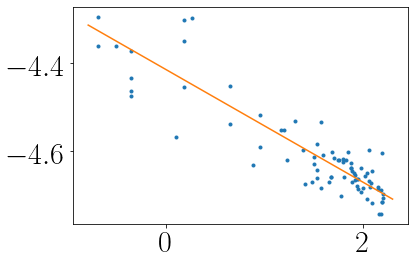

In [69]:
with pm.Model() as model:
    
    # Parameters to infer.
    log_rhk_m = pm.Normal("log_rhk_m", mu=0.0, sd=5)                           # The weight of the x term
    log_rhk_b = pm.Normal("log_rhk_b", mu=np.log(10), sd=5)                    # The constant term
    
    def get_mean_model(age):
        """
        2nd-order polynomial describing relationship between R'HK and age.
        log(R'HK) = m*log(age) + b
        """
        return log_rhk_m * age + log_rhk_b
    
    mean_model = get_mean_model(age)
    pm.Deterministic("mean_model", mean_model)
    
    # Likelihood
    pm.Normal("obs", mu=mean_model, observed=rhk)
        
    map_soln = model.test_point
    map_soln = xo.optimize(map_soln, [log_rhk_m, log_rhk_b])
    
    print("done")
    
plt.plot(age, rhk, ".")
plt.plot(age_plot, map_soln["log_rhk_m"]*age_plot + map_soln["log_rhk_b"])

In [74]:
with pm.Model() as model:
        
    # Parameters to infer.
    age_break = pm.Normal("age_break", mu=1, sigma=.3)                         # the break in age
    b = pm.Normal("b", mu=-4, sd=5)                                            # The constant term
    log_smooth = pm.Normal("log_smooth", mu=np.log(1), sigma=10.0)          # The smoothness of the break. (lower is smoother)
    smooth = tt.exp(log_smooth)
    slope_low = pm.Normal("slope_low", mu=0.0, sd=10.0)                        # The slope below the break
    slope_high = pm.Normal("slope_high", mu=0.0, sd=10.0)                      # The slope above the break
    
    # Mean model
    def get_mean_model(age):
        """
        Predict the age at given values of mass and log(age).
        Use a smoothed broken power law for the age - mass relation.
        Use get_rhk_mass for the R'HK-mass relation.
        """
        delta = age - age_break
        slope = slope_low / (1 + tt.exp(smooth * delta)) + slope_high / (1 + tt.exp(-smooth * delta))
        return slope * delta + b
    
    mean_model = get_mean_model(age)
    pm.Deterministic("mean_model", mean_model)
    
    # Likelihood
    pm.Normal("obs", mu=mean_model, observed=rhk)
        
    map_soln = model.test_point
    map_soln = xo.optimize(map_soln, [slope_low, slope_high])
    map_soln = xo.optimize(map_soln, [log_smooth])
    map_soln = xo.optimize(map_soln, [age_break, b])
    map_soln = xo.optimize(map_soln, [slope_low, slope_high, log_smooth])
    map_soln = xo.optimize(map_soln, [slope_high, slope_low, log_smooth, b, age_break])
    
    print("done")

optimizing logp for variables: [slope_high, slope_low]


message: Optimization terminated successfully.
logp: -99.44448662616495 -> -87.49853836170175


optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -87.49853836170175 -> -87.49315132493996


optimizing logp for variables: [b, age_break]


message: Optimization terminated successfully.
logp: -87.49315132493996 -> -86.69706975459879


optimizing logp for variables: [log_smooth, slope_high, slope_low]


message: Optimization terminated successfully.
logp: -86.69706975459879 -> -85.54968188707834


optimizing logp for variables: [age_break, b, log_smooth, slope_low, slope_high]



done


message: Optimization terminated successfully.
logp: -85.54968188707834 -> -84.6030179397135


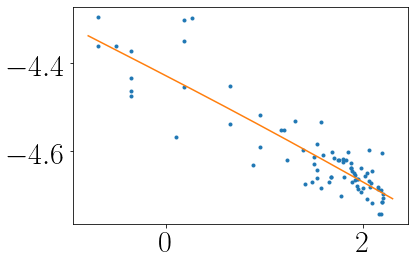

In [75]:
# Mean model
def broken_power_law(age):
    smooth = np.exp(map_soln["log_smooth"])
    delta = age - map_soln["age_break"]
    slope = map_soln["slope_low"] / (1 + np.exp(smooth * delta)) + map_soln["slope_high"] / (1 + np.exp(-smooth * delta))
    return slope * delta + map_soln["b"]

plt.plot(age, rhk, ".")
plt.plot(age_plot, broken_power_law(age_plot))

In [76]:
map_soln

{'age_break': array(0.99974691),
 'b': array(-4.54813964),
 'log_smooth': array(-0.00480377),
 'slope_low': array(-0.11525675),
 'slope_high': array(-0.12649131),
 'mean_model': array([-4.60702056, -4.3500464 , -4.37094851, -4.6683748 , -4.50523395,
        -4.57171548, -4.61778227, -4.38866545, -4.56796539, -4.64130994,
        -4.57535857, -4.6936394 , -4.61251381, -4.67681344, -4.66303362,
        -4.38866545, -4.62033784, -4.69219723, -4.62771395, -4.45110522,
        -4.66120299, -4.68004033, -4.69647627, -4.66483867, -4.69506563,
        -4.59831411, -4.64344295, -4.3500464 , -4.46046433, -4.63240694,
        -4.67681344, -4.45110522, -4.50523395, -4.67843696, -4.65555006,
        -4.65746199, -4.60979649, -4.38866545, -4.65555006, -4.66303362,
        -4.64963835, -4.65555006, -4.64554128, -4.63008179, -4.69647627,
        -4.63469093, -4.63008179, -4.65163914, -4.69506563, -4.6683748 ,
        -4.58570376, -4.69073876, -4.65746199, -4.61778227, -4.67350385,
        -4.54279819,

In [126]:
with pm.Model() as model:
    
    # Parameters to infer.
    m = pm.Normal("m", mu=0.0, sd=5)                           # Slope (mass)
    b = pm.Normal("b", mu=-5, sd=5)                            # Intercept
    a = pm.Normal("a", mu=0.0, sd=5)                            # Slope (age)
    
    def get_mean_model(mass, age):
        return m * mass + b + a*age
    
    mean_model = get_mean_model(mass, age)
    pm.Deterministic("mean_model", mean_model)
    
    # Likelihood
    pm.Normal("obs", mu=mean_model, observed=rhk)
        
    map_soln = model.test_point
    map_soln = xo.optimize(map_soln, [m, b, a])
    
    print("done")

optimizing logp for variables: [a, b, m]



done


message: Optimization terminated successfully.
logp: -86.77810629627245 -> -80.26705325119428


In [127]:
def model(mass, age, map_soln):
    return map_soln["m"] * mass + map_soln["b"] + map_soln["a"]*age

In [128]:
import matplotlib

def get_color(x2, vmin, vmax, cmap):
    return cmap((x2 - vmin) / (vmax - vmin))

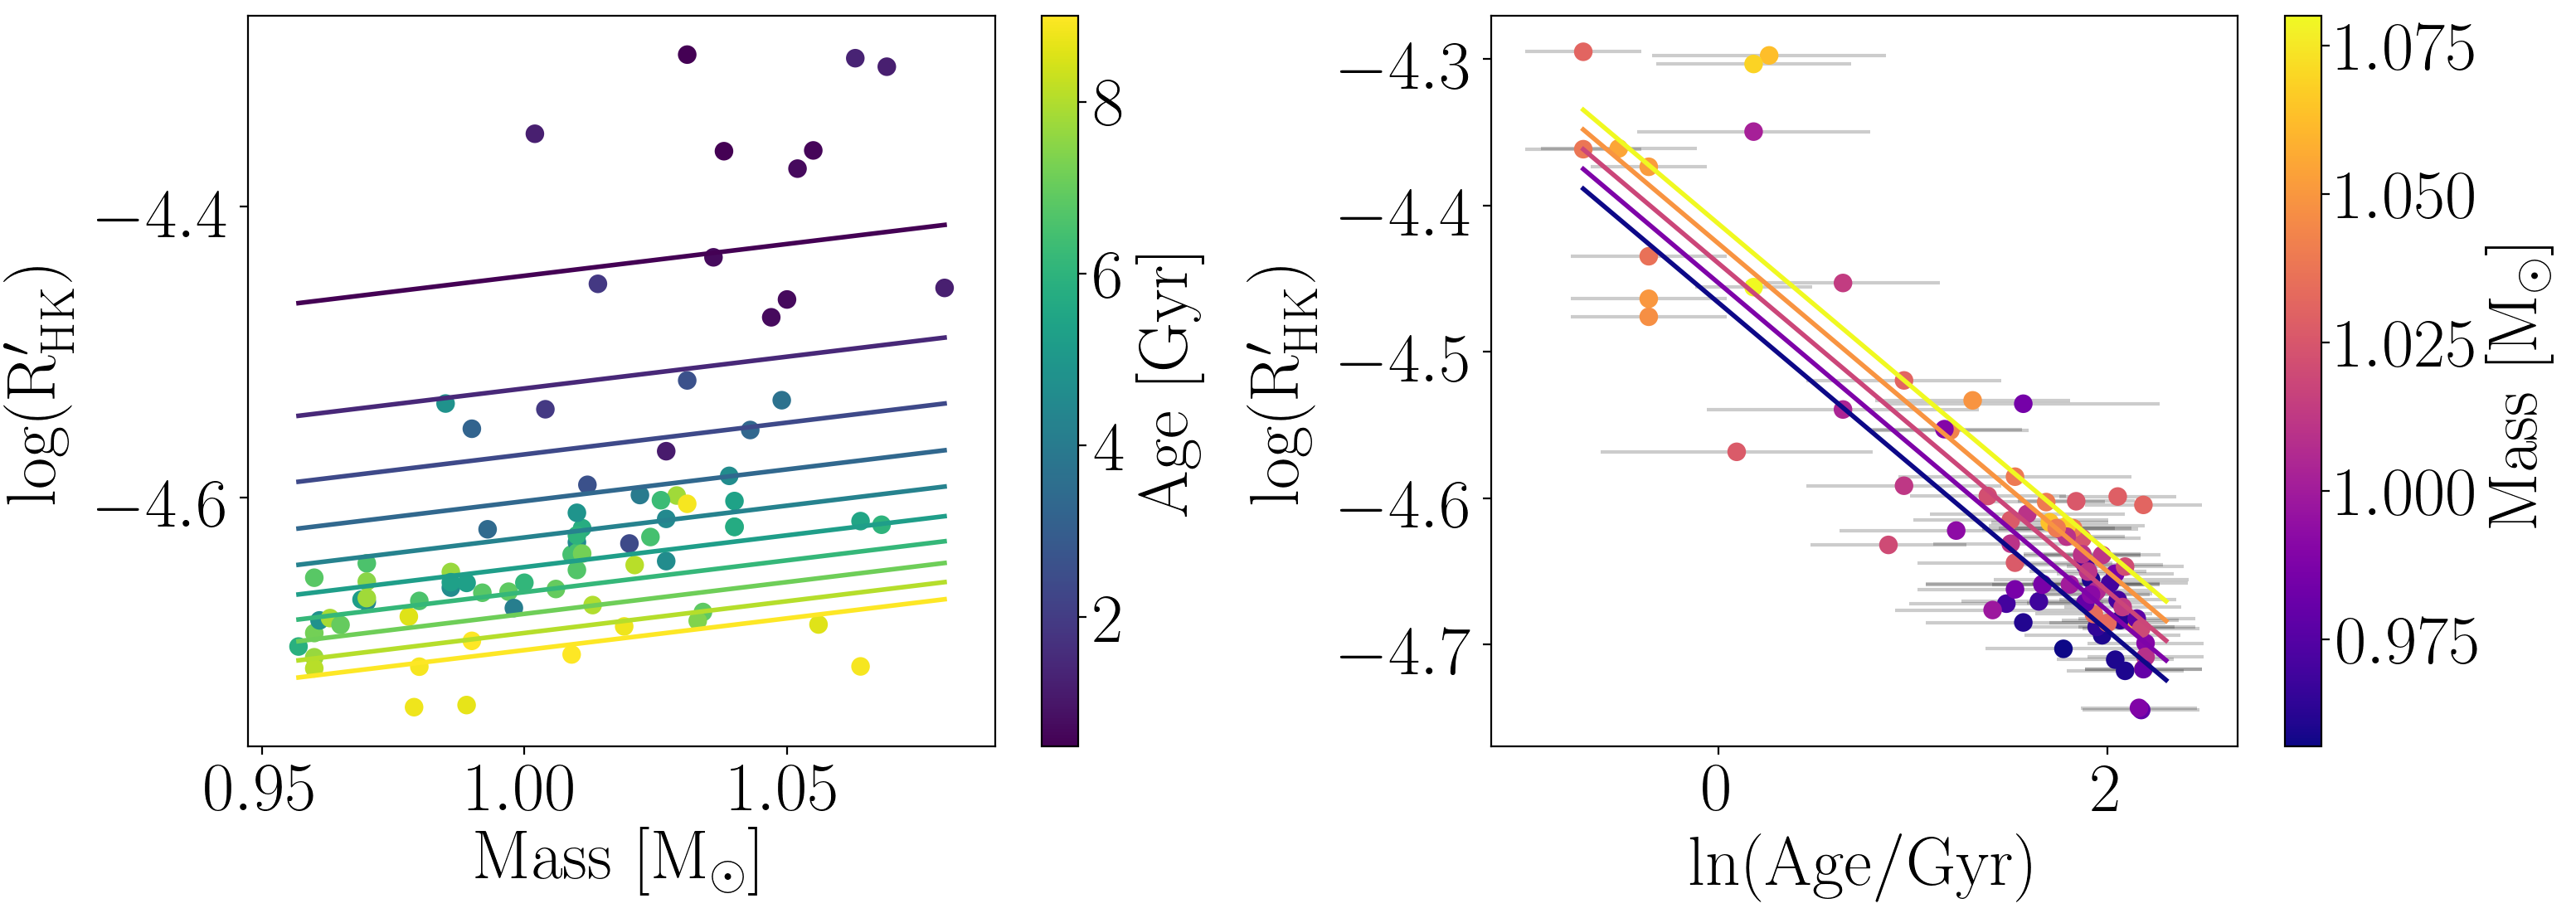

In [129]:
fig = plt.figure(figsize=(16, 6), dpi=200)
ax0 = fig.add_subplot(121)
cb = ax0.scatter(df.M_iso, log_r_prime_hk, c=df["Age_iso"], s=50)
plt.colorbar(cb, label="$\mathrm{Age~[Gyr]}$")
ax0.set_xlabel("$\mathrm{Mass~[M_\odot]}$")
ax0.set_ylabel("$\mathrm{\log(R'_{HK})}$");
masses = np.linspace(min(mass), max(mass), 100)
# ax0.plot(masses, map_soln["m"]*masses + map_soln["b"])

masses = np.linspace(min(mass), max(mass), 100)
rhks = np.linspace(min(rhk), max(rhk), 100)
rhk_plot = np.linspace(min(rhk), max(rhk), 10)
ages = np.log(np.linspace(.5, 10, 100))
age_plot = np.linspace(1, 10, 10)
mass_plot = np.linspace(min(mass), max(mass), 5)

vmin = age_plot.min()
vmax = age_plot.max()
cmap = matplotlib.cm.get_cmap("viridis")

for i in range(len(age_plot)):
    plt.plot(masses, model(masses, np.log(age_plot[i]), map_soln), color=get_color(age_plot[i], vmin, vmax, cmap), lw=2)

ax1 = fig.add_subplot(122)
ax1.errorbar(age, log_r_prime_hk, xerr=df["Age_err"], alpha=.2, fmt="k.", zorder=0)
cb = ax1.scatter(age, log_r_prime_hk, c=df.M_iso, s=50, zorder=1, cmap="plasma")
plt.colorbar(cb, label="$\mathrm{Mass~[M_\odot]}$")
ax1.set_xlabel("$\mathrm{\ln(Age/Gyr)}$")
ax1.set_ylabel("$\mathrm{\log(R'_{HK})}$");

vmin = mass.min()
vmax = mass.max()
cmap = matplotlib.cm.get_cmap("plasma")

for i in range(len(mass_plot)):
#     ax1.plot(ages, model(mass_plot[i], ages, map_soln), color="k", lw=1.25)
    plt.plot(ages, model(mass_plot[i], ages, map_soln), color=get_color(mass_plot[i], vmin, vmax, cmap), lw=2)
    
plt.tight_layout()

In [132]:
with pm.Model() as model:
    
    # Parameters to infer.
    m = pm.Normal("m", mu=0.0, sd=5)                           # Slope (mass)
    b = pm.Normal("b", mu=-5, sd=5)                            # Intercept
    a = pm.Normal("a", mu=0.0, sd=5)                            # Slope (rhk)
    
    def get_mean_model(mass, rhk):
        return m * mass + b + a*rhk
    
    mean_model = get_mean_model(mass, rhk)
    pm.Deterministic("mean_model", mean_model)
    
    # Likelihood
    pm.Normal("obs", mu=mean_model, sigma=age_err, observed=age)
        
    map_soln = model.test_point
    map_soln = xo.optimize(map_soln, [m, b, a])
    
    print("done")

optimizing logp for variables: [a, b, m]



done


message: Optimization terminated successfully.
logp: -638136.3238067499 -> -249.81260715064883


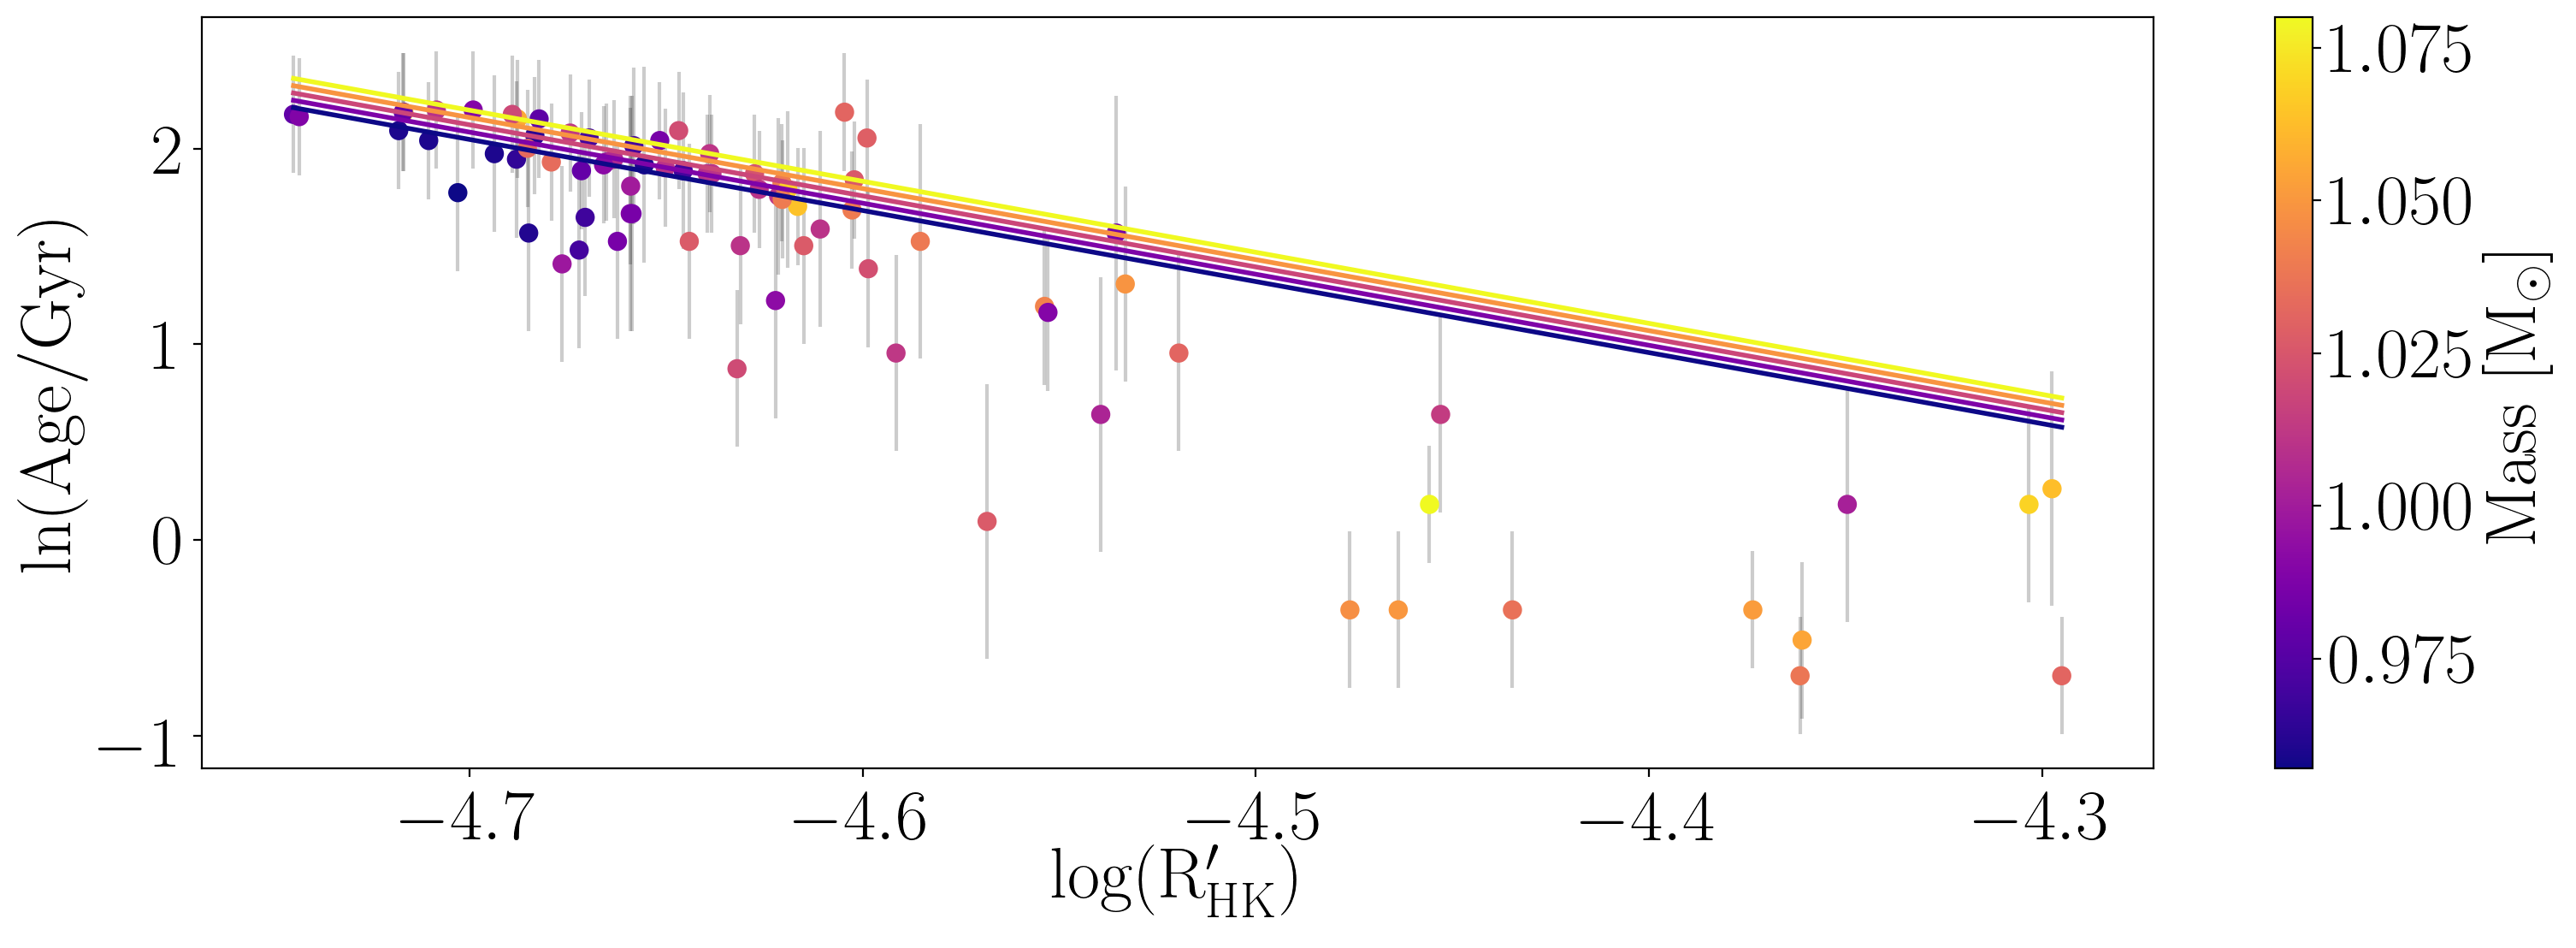

In [133]:
def model2(mass, rhk, map_soln):
    return map_soln["m"] * mass + map_soln["b"] + map_soln["a"]*rhk

fig = plt.figure(figsize=(16, 6), dpi=200)
ax1 = fig.add_subplot(111)
ax1.errorbar(log_r_prime_hk, age, yerr=df["Age_err"], alpha=.2, fmt="k.", zorder=0)
cb = ax1.scatter(log_r_prime_hk, age, c=df.M_iso, s=50, zorder=1, cmap="plasma")
plt.colorbar(cb, label="$\mathrm{Mass~[M_\odot]}$")
ax1.set_ylabel("$\mathrm{\ln(Age/Gyr)}$")
ax1.set_xlabel("$\mathrm{\log(R'_{HK})}$");

vmin = mass.min()
vmax = mass.max()
cmap = matplotlib.cm.get_cmap("plasma")

for i in range(len(mass_plot)):
#     ax1.plot(ages, model(mass_plot[i], ages, map_soln), color="k", lw=1.25)
    plt.plot(rhks, model2(mass_plot[i], rhks, map_soln), color=get_color(mass_plot[i], vmin, vmax, cmap), lw=2)
    
plt.tight_layout()